# Nested sampling and the transient universe


Let's go back to our previous example on the astrophysical transient.

Fit the same model from before with the same priors,  but this time use nested sampling.

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors (I used `ppf` from `scipy.stats.uniform`, but there are other ways to do it)

An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did earlier.



In [2]:
import numpy as np
from dynesty import NestedSampler
import matplotlib.pyplot as plt
import dynesty.plotting as dyplot

In [3]:
import warnings
warnings.filterwarnings("ignore")


In [5]:
data = np.load("data/transient.npy")

In [52]:
# ---- Model ----
def model(theta,t):
    A,b,t0,alpha=theta 
    return np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0)))

# ---- Prior transform ----
def prior_transform(u):
    # u is in [0,1]; map to actual parameter ranges
    A = 0 + u[0] * 50       # A in [0,50]
    b = 0 + u[1] * 50       # b in [0,50]
    t0 = 0 + u[2] * 100       # t0 in [0,100] 
    alpha = np.exp(-5) + u[3] * (np.exp(5) - np.exp(-5))  #alpha in (e^-5,e^5)
    return [A, b, t0, alpha]

t = data[:,0]
flux_data = data[:,1]
err = data[:,2]

# ---- Log-likelihood ----
def log_likelihood(theta):
    y_model = model(theta, t)
    chi2 = np.sum((flux_data - y_model)**2 / err**2)
    return -0.5 * chi2

# ---- Run Nested Sampler ----
sampler = NestedSampler(log_likelihood, prior_transform, ndim=4, nlive=500)
sampler.run_nested()
results = sampler.results

10212it [03:16, 51.97it/s, +500 | bound: 1759 | nc: 1 | ncall: 1338107 | eff(%):  0.801 | loglstar:   -inf < -48.762 <    inf | logz: -68.399 +/-  0.196 | dlogz:  0.001 >  0.509]


In [53]:
logZ_exp = results.logz[-1]        # Final log evidence
logZ_exp_err = results.logzerr[-1] # Estimated uncertainty in logZ

print(f"logZ = {logZ_exp:.3f} ± {logZ_exp_err:.3f}")

logZ = -68.399 ± 0.347


In [14]:
print(results.samples.shape)

(10750, 4)


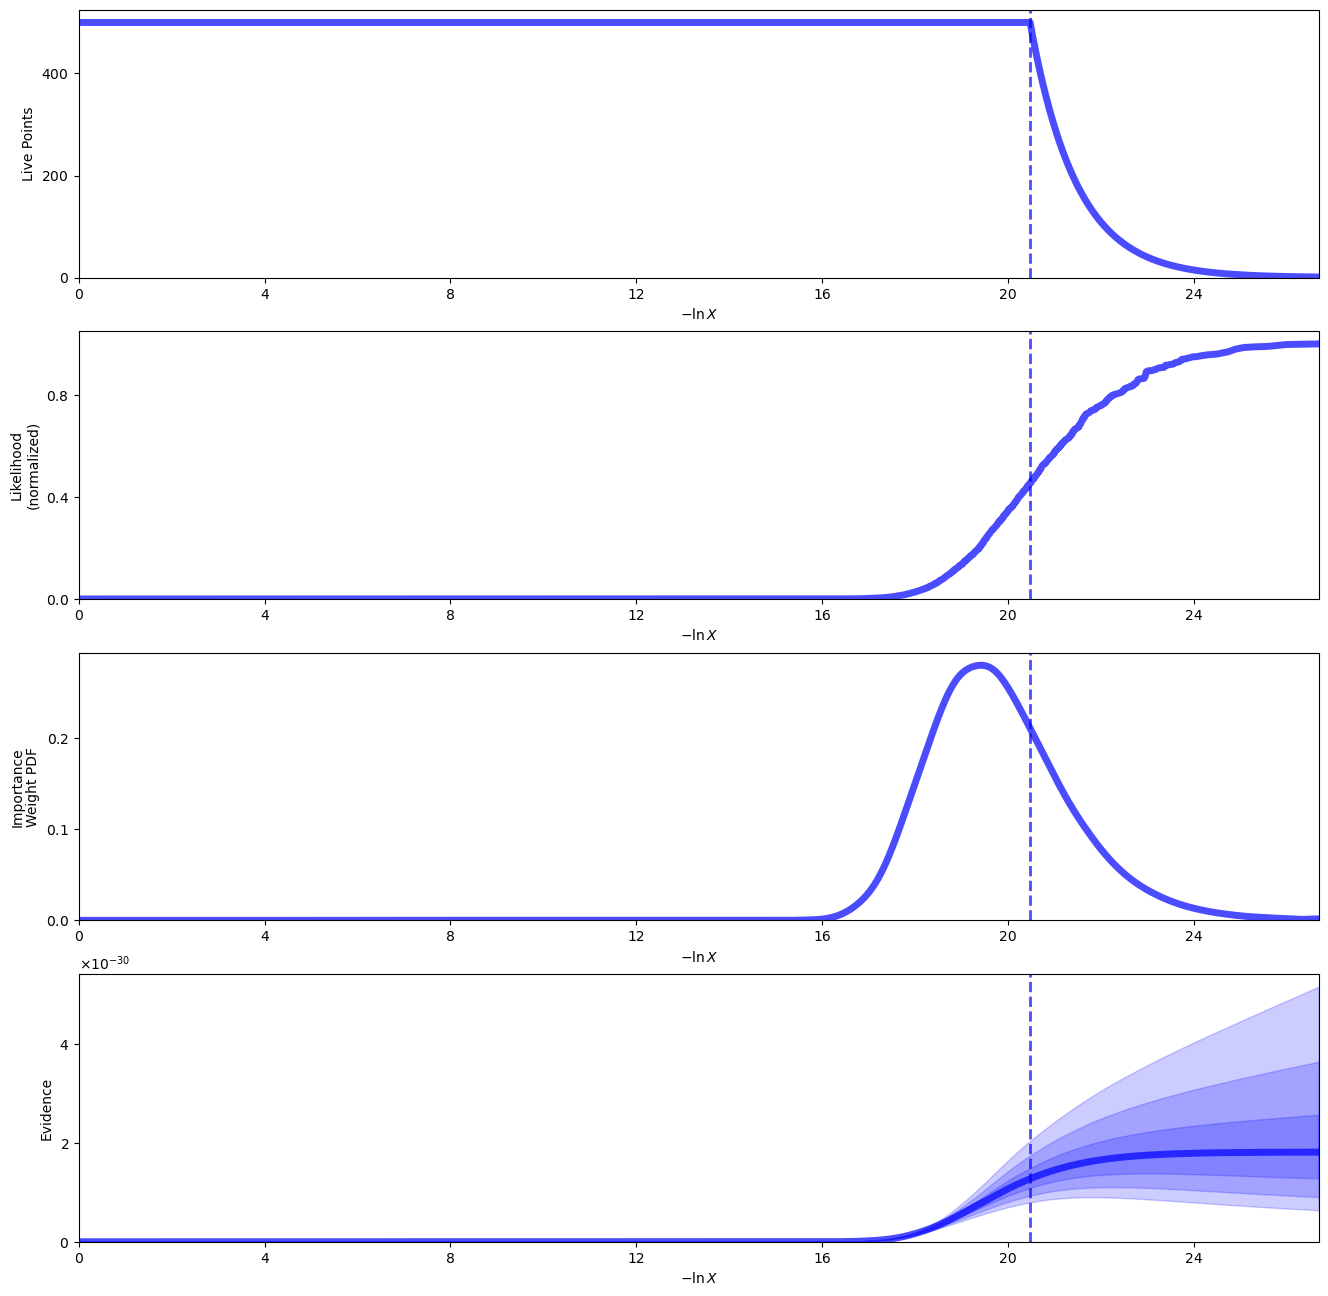

In [7]:
rfig, raxes = dyplot.runplot(results)

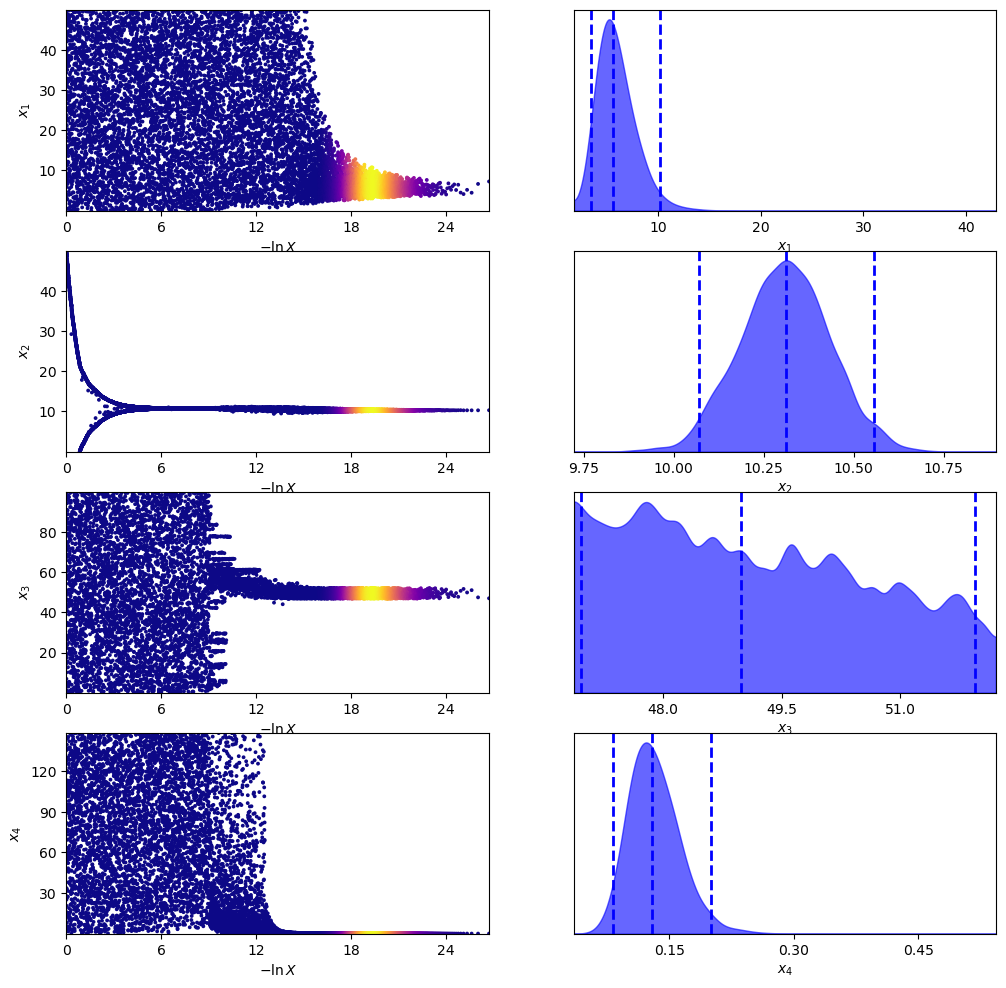

In [8]:
tfig, taxes = dyplot.traceplot(results)

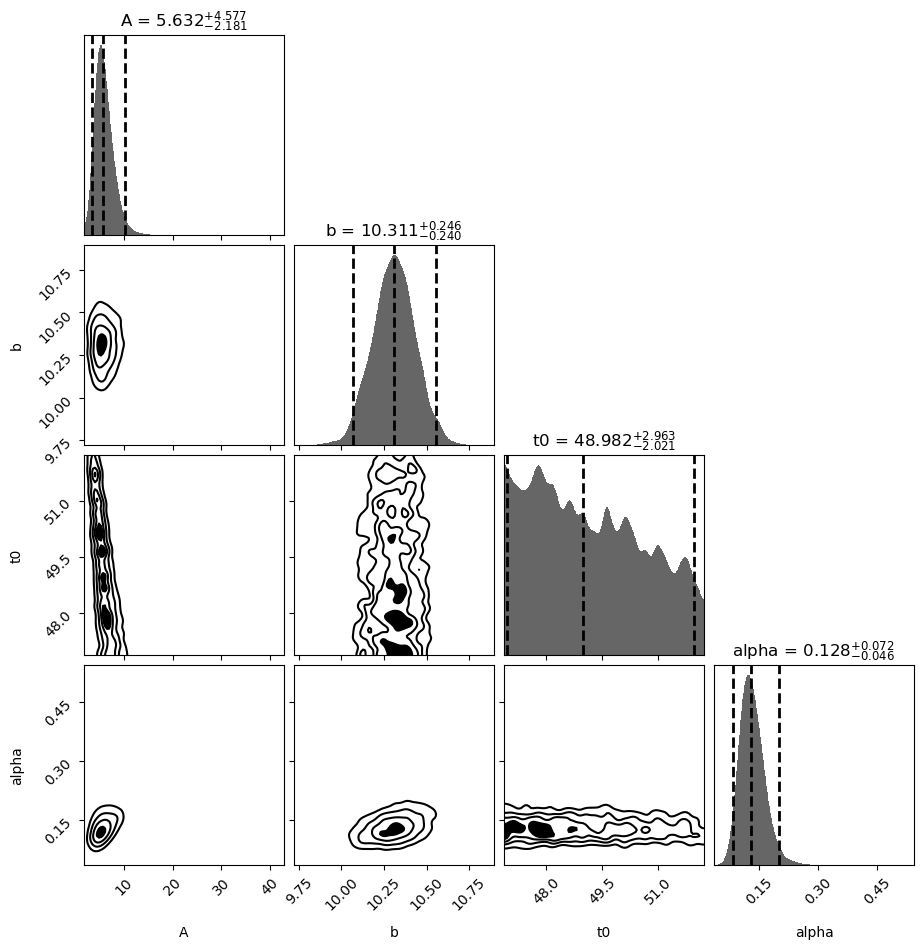

In [17]:
import corner
from dynesty import utils as dyfunc
from dynesty import plotting as dyplot

# ---- Plot posterior ----
fig, axes = dyplot.cornerplot(results, show_titles=True, title_fmt='.3f',labels=["A","b","t0","alpha"])
plt.show()

# dyplot.cornerplot(results, ...)
# This uses the raw nested samples and log-weights to create the corner plot.
# Pros: Fast, directly reflects the weighted posterior.
# Cons: Smoothed via KDE, and weighted, so may not look like typical MCMC chains.
# It's good for an initial diagnostic, but:
# You can't directly compute summary statistics or credible intervals from it.
# You see posterior shapes, but not equally weighted samples.


In Bayesian inference, we want to compute:
- The posterior distribution:

$$p(\theta∣\text{data})=\frac{p(\text{data}∣\theta)p(\theta)}{\mathcal{Z}}$$

- where $\mathcal{Z}$ is the evidence.

Nested sampling doesn't give you samples from the posterior directly. Instead, it gives you a set of samples $\theta_i$​, each with:
- A likelihood $\mathcal{L}=p(\text{data}∣\theta_i)$
- A corresponding prior volume shrinkage $X_i$​
- A computed weight $w_i\approx\mathcal{L}_i(X_{i−1}−Xi)$

These samples are not equally spaced in the prior volume — later samples are drawn from shrinking regions with higher likelihood. Weights are used to approximate the evidence:

$$\mathcal{Z}\approx\sum_i w_i$$

Are also used to recover the posterior:

$$p(\theta_i∣\text{data})=\frac{w_i}{\mathcal{Z}}$$

You have many samples, but each contributes a different amount to the posterior — that’s what “weighted” means. 

Why we resample:

To do typical posterior analysis — histograms, quantiles, etc. — we want samples that are **equally probable**, i.e. drawn from the posterior. So we use:

`samples_equal = dyfunc.resample_equal(samples, weights)`

which takes the original weighted samples and draws a new set of unweighted samples from the posterior. Resampling creates a new set of samples:

- Still from your original samples
- But with replacement, in proportion to their weights

So that the resulting samples are uniform in probability, i.e., they mimic a draw from the true posterior.

In [19]:
samples = results.samples  # samples
weights = np.exp(results.logwt - results.logz[-1])  # normalized weights
samples_equal = dyfunc.resample_equal(samples, weights)

In [20]:
print(samples_equal.shape)

(10750, 4)


In [23]:
print(samples[0])
print(samples_equal[0])

[23.10886468 49.95788776 12.39460551 13.94605864]
[ 7.26379156 10.28312744 46.87397129  0.10731172]


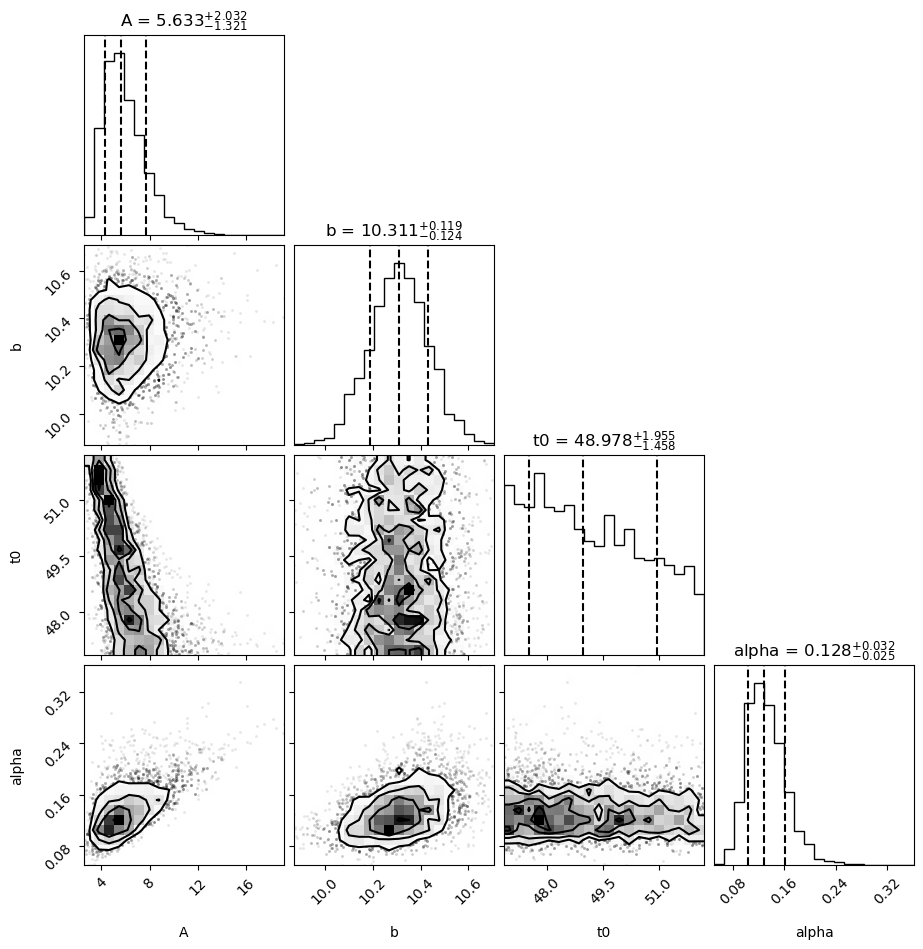

In [29]:
corner.corner(
    samples_equal,
    labels=["A", "b", "t0", "alpha"],
    show_titles=True,
    title_fmt=".3f",
    quantiles=[0.16, 0.5, 0.84],  # 68% credible interval
    title_kwargs={"fontsize": 12}
);

## Bayesian model comparison

Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

Fit this model usign nested sampling and reasonable priors (this time is up to you to decide...)

Unlike MCMCs, nested sampling provides the Bayesian evidence. Compute the Bayesian evidence for this Gaussian model, and for the original burst model. Which model is the favored description of the data? Express this in terms of the Jeffrey's scale.

In [48]:
# ---- Model ----
def gaussian_model(theta,t):
    A,b,t0,sigma=theta 
    return b + A*np.exp(-(t-t0)**2/(2*sigma**2))

t = data[:,0]
flux_data = data[:,1]
err = data[:,2]

# ---- Prior transform ----
def prior_transform(u):
    # u is in [0,1]; map to actual parameter ranges
    A = 0 + u[0] * 50       # A in [0,50]
    b = 0 + u[1] * 50       # b in [0,50]
    t0 = 0 + u[2] * 100       # t0 in [0,100] 
    sigma = 1e-1 + u[3] * (1e-1 - 1e2)  #sigma in (1e-1,1e2)
    return [A, b, t0, sigma]

8813it [00:58, 150.15it/s, +500 | bound: 236 | nc: 1 | ncall: 194006 | eff(%):  4.813 | loglstar:   -inf < -52.458 <    inf | logz: -69.347 +/-  0.183 | dlogz:  0.001 >  0.509]


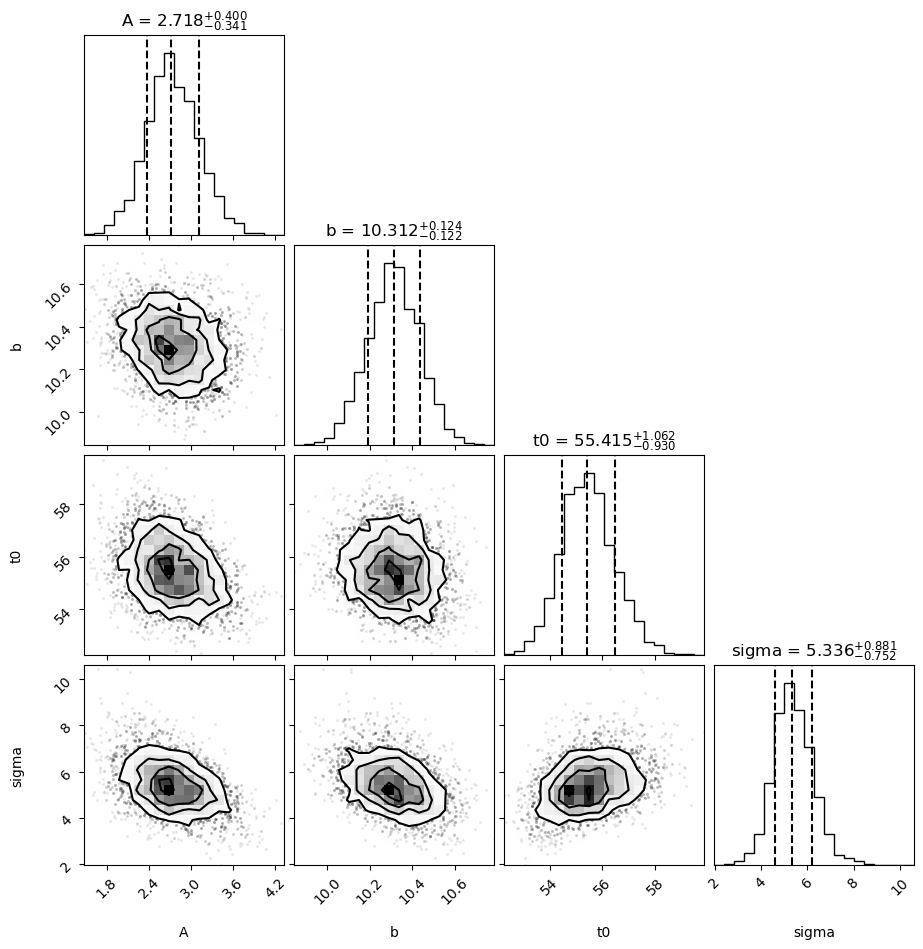

In [55]:
# ---- Log-likelihood ----
def log_likelihood(theta):
    y_model = gaussian_model(theta, t)
    chi2 = np.sum((flux_data - y_model)**2 / err**2)
    return -0.5 * chi2

# ---- Run Nested Sampler ----
sampler = NestedSampler(log_likelihood, prior_transform, ndim=4, nlive=500)
sampler.run_nested()
results = sampler.results

samples = results.samples  # samples
weights = np.exp(results.logwt - results.logz[-1])  # normalized weights
samples_equal = dyfunc.resample_equal(samples, weights)

corner.corner(
    samples_equal,
    labels=["A", "b", "t0", "sigma"],
    show_titles=True,
    title_fmt=".3f",
    quantiles=[0.16, 0.5, 0.84],  # 68% credible interval
    title_kwargs={"fontsize": 12}
);

In [51]:
logZ_gaus = results.logz[-1]        # Final log evidence
logZ_gaus_err = results.logzerr[-1] # Estimated uncertainty in logZ

print(f"logZ = {logZ_gaus:.3f} ± {logZ_gaus_err:.3f}")

logZ = -69.543 ± 0.320


In [57]:
Bayes_factor = np.exp(logZ_exp) / np.exp(logZ_gaus)
print('Bayes factor: ',Bayes_factor)
print('log(Bayes factor): ',np.log(Bayes_factor))

Bayes factor:  3.1409650527692
log(Bayes factor):  1.1445300943466352


### Strenght of evidence is substantial according to Jeffreys scale

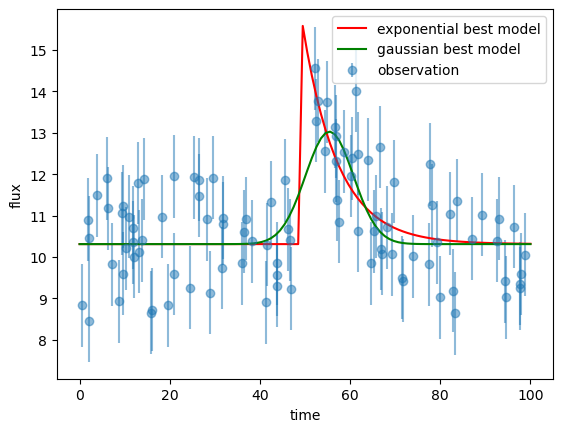

In [59]:
plt.errorbar(data[:,0],data[:,1],data[:,2],linestyle='None', marker='o',label='observation',alpha=0.5)
plt.xlabel("time")
plt.ylabel("flux")

parameters_exp_model = [5.63,10.31,48.98,0.128]
parameters_gauss_model = [2.718,10.31,55.415,5.336]


times = np.linspace(0,100,100)
exp = model(parameters_exp_model,times)
gaus = gaussian_model(parameters_gauss_model,times)

plt.plot(times,exp,c='red',label='exponential best model')
plt.plot(times,gaus,c='green',label='gaussian best model')
plt.legend()
plt.show()
